In [1]:
# настройка размера графиков
options(repr.plot.width = 8, repr.plot.height = 6)

## Регрессия: [датасет Yacht Hydrodynamics](http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics)

Для парусных яхт нужно предсказать остаточное сопротивление на единицу массы смещения от размеров яхты и ее скорости.

### Загрузка данных

In [2]:
data <- read.table('yacht_hydrodynamics.data', header = TRUE, sep = ',')
data[1:5,]

,Longitudinal_position,Prismatic_coefficient,Length.displacement_ratio,Beam.draught_ratio,Length.beam_ratio,Froude_number,Residuary_resistance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
2,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
3,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
4,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
5,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


### Разбиение данных на обучающую и тестовую выборки
[createDataPartition](https://www.rdocumentation.org/packages/caret/versions/6.0-86/topics/createDataPartition) `(y,
  times = 1,
  p = 0.5,
  list = TRUE,
  groups = min(5, length(y))
)` — функция для разделения данных. Требуется пакет 'caret'.

Возвращает индексы объектов для обучения.

* `y` — данные;

* `times` — колличество разделений;

* `p` — процент данных для train'а;

* `list` — если TRUE, результат в виде списка, иначе матрица с floor(p * length(y)) строками и times столбцами;

* `groups` — для числовых данных количество разбиений данных по квантилям для дальнейшего сэмплирования в каждом промежутке.


In [1]:
# установка пакета
install.packages('caret')
library(caret)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘glue’, ‘lifecycle’, ‘rlang’, ‘vctrs’, ‘prodlim’, ‘cpp11’, ‘iterators’, ‘data.table’, ‘dplyr’, ‘generics’, ‘gower’, ‘ipred’, ‘lubridate’, ‘purrr’, ‘tidyr’, ‘tidyselect’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’, ‘pROC’


Warning message in install.packages("caret"):
“installation of package ‘lava’ had non-zero exit status”
Warning message in install.packages("caret"):
“installation of package ‘prodlim’ had non-zero exit status”
Warning message in install.packages("caret"):
“installation of package ‘ipred’ had non-zero exit status”
Warning message in install.packages("caret"):
“installation of package ‘recipes’ had non-zero exit status”
Warning message in install.packages("caret"):
“installation of package ‘caret’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: Error in library(caret): there is no package called ‘caret’


In [4]:
# разбиение данных
partition <- createDataPartition(data$Residuary_resistance, p = 0.7, list = FALSE)
train <- data[partition,]
test <- data[-partition,]

### Обучение

[lm](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/lm)`(formula, data, subset, weights, na.action,
   method = "qr", model = TRUE, x = FALSE, y = FALSE, qr = TRUE,
   singular.ok = TRUE, contrasts = NULL, offset, …)` — функция для построения линейных моделей.

   * `formula` — формула;
   * `data` — данные;
   * `subset` — указывает на подмножество наблюдений, которые нужно использоваться для обучения;
   * `weights` — веса для взвешенного МНК;
   * `na.action` — функция, указывающая, что делать с пропусками.

Возврвщает объект с полями:
* `coefficients` — вектор коэффициентов
* `residuals` — остатки модели

Полная справка:

In [5]:
#?lm

Обучаем на train модель вида $Residuary\_resistance  \sim \theta_1 + \theta_1 \cdot Froude_number$.

In [6]:
# обучение модели
model <- lm(formula = Residuary_resistance ~ Froude_number, data = train)
model


Call:
lm(formula = Residuary_resistance ~ Froude_number, data = train)

Coefficients:
  (Intercept)  Froude_number  
        -25.1          123.3  


Оценки параметров линейной регрессии:

In [7]:
# все коэффициенты
model$coefficients 

# взять первый коэффициент
model$coefficients[1]

(Intercept) Froude_number 
    -25.09753     123.29883

(Intercept) 
  -25.09753

Ковариационная матрица вектора $\widehat \theta$ в условиях гомоскедастичности:

In [8]:
vcov(model)

,(Intercept),Froude_number
(Intercept),3.46472,-10.71682
Froude_number,-10.71682,37.09670


Для записи формулы, с зависимостью от нескольких параметров, например $Residuary\_resistance  \sim \theta_1 + \theta_1 \cdot Froude_number + \theta_2 \cdot Prismatic\_coefficient$, можно записать названия признаков через `+`.

In [9]:
model2 <- lm(formula = Residuary_resistance ~ Froude_number + Prismatic_coefficient, data = train)
model2


Call:
lm(formula = Residuary_resistance ~ Froude_number + Prismatic_coefficient, 
    data = train)

Coefficients:
          (Intercept)          Froude_number  Prismatic_coefficient  
               -16.36                 123.51                 -15.58  


### Свойства (в гауссовской линейной модели)
Функция [summary](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/summary)`(object, …)` печатает:

* Остатки: минимум, 0.25-квантиль, медиана, 0.75-квантиль, максимум
* Для каждого коэффициента: его оценка, стандартная ошибка, значение t-статистики гипотезы о
незначимости коэффициента, pvalue этой гипотезы, звездочки значимости (чем больше, тем более
значим коэффициент)
* RSS и число степеней свободы, R^2 и его поправленная версия, значение F-статистики критерия
Фишера о значимости регрессии вообще, число степеней свободы распределения Фишера, pvalue
этой гипотезы.

Для данной модели оба признака значимы, поскольку pvalue мало. То есть отвергаются гипотезы $\theta_1 = 0$ и $\theta_2 = 0$.

In [10]:
summary(model)


Call:
lm(formula = Residuary_resistance ~ Froude_number, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.197  -7.415  -1.605   6.690  30.463 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -25.098      1.861  -13.48   <2e-16 ***
Froude_number  123.299      6.091   20.24   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.925 on 214 degrees of freedom
Multiple R-squared:  0.6569,	Adjusted R-squared:  0.6553 
F-statistic: 409.8 on 1 and 214 DF,  p-value: < 2.2e-16


Можно вытащить отдельные числа:



In [11]:
summary(model)$r.squared

[1] 0.6569469

Доверительные интервалы для коэффициентов:

In [12]:
confint(model, level = 0.95)

,2.5 %,97.5 %
(Intercept),-28.76651,-21.42855
Froude_number,111.29337,135.30429


### Предсказания
Предсказания строятся с помощью универсальной функции predict . Для линейной регрессии она
эквивалентна функции predict.lm .


[predict](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/predict.lm)`(object, newdata, se.fit = FALSE, scale = NULL, df = Inf,
        interval = c("none", "confidence", "prediction"),
        level = 0.95, type = c("response", "terms"),
        terms = NULL, na.action = na.pass,
        pred.var = res.var/weights, weights = 1, …)`

* object — обученная ранее модель;
* se.fit — индикатор того, что требуется подсчет стандартных ошибок;
* scale — параметр для подсчета std.err;
* df — степени свободы scale;
* level — уровень доверия;
* interval — тип интервала.

По ней можно получить справку:

In [13]:
# ?predict.lm

В предположениях гауссовской линейной модели можно построить два типа интервалов —
доверительный ( confidence ) и предсказательный ( prediction ). Первый является доверительными
интервалом в обычном смысле для среднего значения отклика. Второй является интервалом, в котором
с большой вероятностью лежит само значение отклика. Второй итервал всегда шире первого.

Доверительный интервал для  $x_{new}\theta$ :
$$x_{new}^T\hat\theta \pm T_{n -k - 1, 1 -  \alpha/2} \hat \sigma \sqrt{x_{new}^T(X^TX)^{-1}x_{new}}$$

Предсказательный интервал для $x_{new} \theta + \varepsilon$:
$$x_{new}^T\hat\theta \pm T_{n -k - 1, 1 - \alpha / 2} \hat \sigma \sqrt{1 + x_{new}^T(X^TX)^{-1}x_{new}}$$

Предсказание значений на новых объектах вместе с доверительным интервалом:

In [14]:
predicted <- predict(model, test, level = 0.95, interval = 'confidence')
predicted[1:3,]

,fit,lwr,upr
25,21.139529,19.55793,22.721123
26,24.222000,22.42977,26.014229
29,-9.685178,-11.98822,-7.382139


Предсказание значений на новых объектах вместе с предсказательным интервалом:

In [15]:
predicted <- predict(model, test, level = 0.95, interval = 'prediction')
predicted[1:3,]

,fit,lwr,upr
25,21.139529,3.477059,38.80200
26,24.222000,6.539424,41.90458
29,-9.685178,-27.426807,8.05645


MSE посчитаем ручками.

In [16]:
mean((predicted[,1] - test$Residuary_resistance) ^ 2)

[1] 78.53378

Посмотрим на график предсказания.

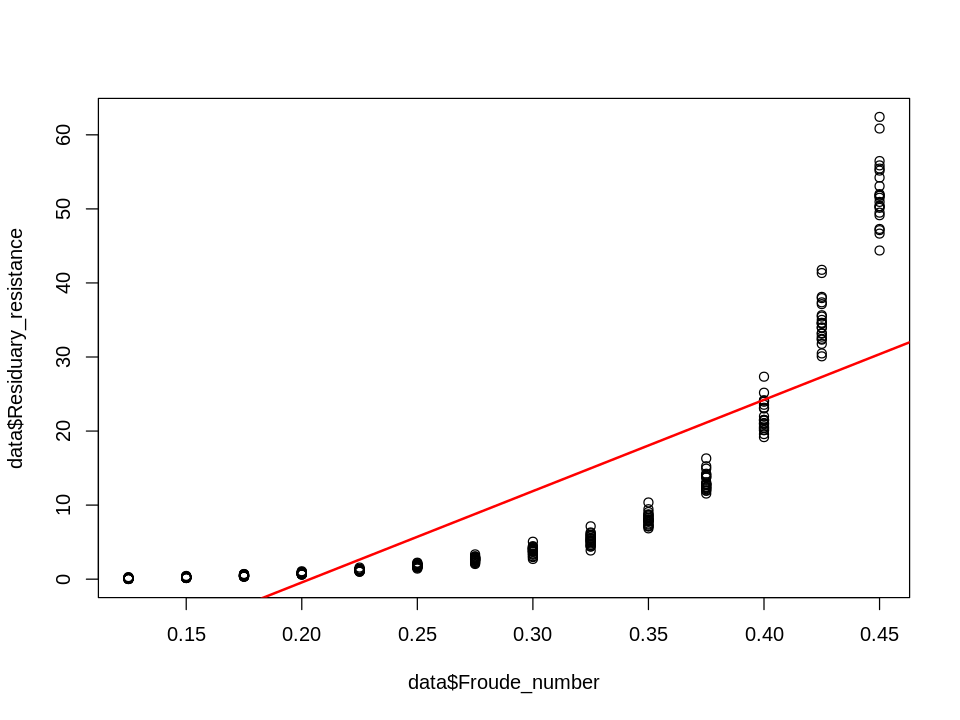

In [17]:
plot(data$Residuary_resistance ~ data$Froude_number)
x <- seq(from = 0, to = 0.5, by = 0.1)
lines(x, model$coefficients[1] + model$coefficients[2] * x, col = "red", lwd = 2)

### Еще примеры

Обучаем на train модель вида $Residuary\_resistance = \theta_1 + \theta_2 \cdot Froude\_number + \theta_3 \cdot Froude\_number^2 + \theta_4 \cdot Froude\_number^3$

*Обозначения в формуле:*

`(x+y)^2` эквивалентно `x^2 + y^2 + xy`, что означает взять признаки `x^2`, `y^2`, `xy`

`I((x+y)^2)` означает взять признак `(x+y)^2`.

In [18]:
model_2 <- lm(
    formula = Residuary_resistance ~ Froude_number + I(Froude_number^2) + I(Froude_number^3), 
    data = train
)
model_2$coefficients
summary(model_2)

(Intercept)      Froude_number I(Froude_number^2) I(Froude_number^3) 
         -47.51351          684.90034        -3105.79892         4592.52783


Call:
lm(formula = Residuary_resistance ~ Froude_number + I(Froude_number^2) + 
    I(Froude_number^3), data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8815 -1.1699 -0.2189  1.1542 10.5885 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -47.514      3.253  -14.61   <2e-16 ***
Froude_number        684.900     38.674   17.71   <2e-16 ***
I(Froude_number^2) -3105.799    141.931  -21.88   <2e-16 ***
I(Froude_number^3)  4592.528    163.041   28.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.853 on 212 degrees of freedom
Multiple R-squared:  0.9853,	Adjusted R-squared:  0.9851 
F-statistic:  4752 on 3 and 212 DF,  p-value: < 2.2e-16


Сравнить две модели можно в одной таблице при помощи функции mtable.

In [19]:
install.packages('memisc')
library("memisc")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: MASS


Attaching package: ‘memisc’


The following object is masked from ‘package:ggplot2’:

    syms


The following objects are masked from ‘package:stats’:

    contr.sum, contr.treatment, contrasts


The following object is masked from ‘package:base’:

    as.array




In [20]:
print(mtable(model, model_2))


Calls:
model: lm(formula = Residuary_resistance ~ Froude_number, data = train)
model_2: lm(formula = Residuary_resistance ~ Froude_number + I(Froude_number^2) + 
    I(Froude_number^3), data = train)

                        model       model_2     
------------------------------------------------
  (Intercept)         -25.098***    -47.514***  
                       (1.861)       (3.253)    
  Froude_number       123.299***    684.900***  
                       (6.091)      (38.674)    
  I(Froude_number^2)              -3105.799***  
                                   (141.931)    
  I(Froude_number^3)               4592.528***  
                                   (163.041)    
------------------------------------------------
  R-squared             0.657         0.985     
  N                   216           216         
  Significance: *** = p < 0.001;   
                ** = p < 0.01; * = p < 0.05  


Значение MSE куда меньше во второй модели.

In [21]:
predicted <- predict(model_2, test)
mean((predicted - test$Residuary_resistance) ^ 2)

[1] 4.77754

Посмотрим на график:

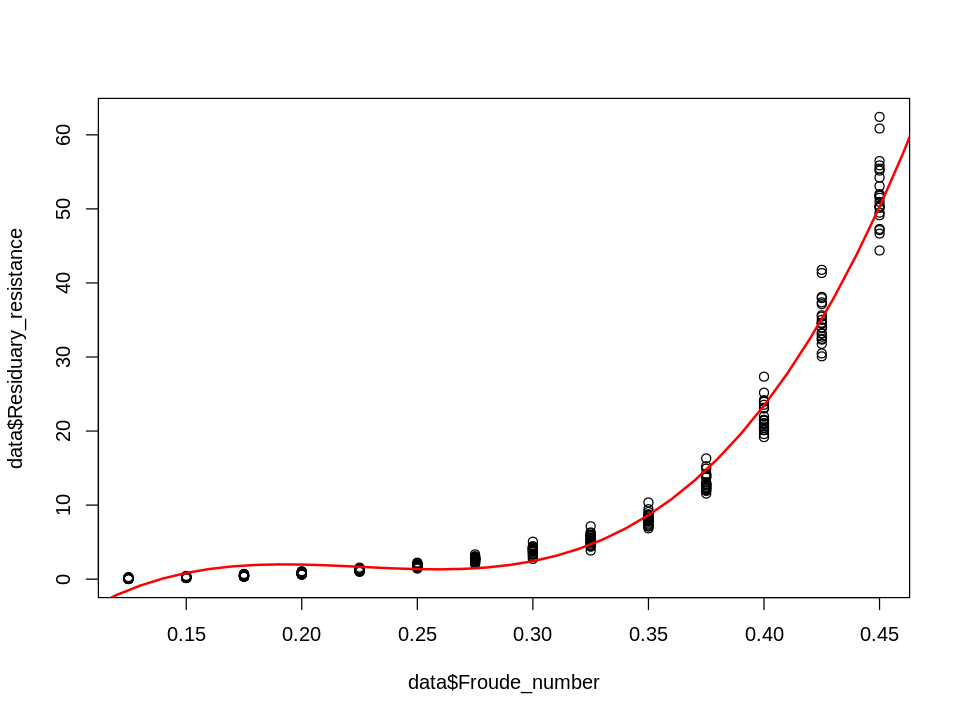

In [22]:
plot(data$Residuary_resistance ~ data$Froude_number)
x <- seq(from = 0, to = 0.5, by = 0.01)
lines(x, 
      model_2$coefficients[1] + model_2$coefficients[2] * x + model_2$coefficients[3] * x^2 + model_2$coefficients[4] * x^3, 
      col = "red", lwd = 2)

Обучим регрессию на всех фичах. Как видим, все остальные фичи незначимы - pvalue мало.

*Чтобы взять в формулу все признаки, можно поставить просто точку*

In [23]:
model <- lm(formula = Residuary_resistance ~ . + I(Froude_number^2) + I(Froude_number^3), 
            data = train)
model$coefficients
summary(model)

(Intercept)     Longitudinal_position     Prismatic_coefficient 
              -48.8736627                 0.2364082                 1.6404866 
Length.displacement_ratio        Beam.draught_ratio         Length.beam_ratio 
                6.0167135                -2.3958634                -5.9975408 
            Froude_number        I(Froude_number^2)        I(Froude_number^3) 
              695.3908837             -3143.7634888              4634.6105447


Call:
lm(formula = Residuary_resistance ~ . + I(Froude_number^2) + 
    I(Froude_number^3), data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4293 -1.0783 -0.1308  1.0368  9.3284 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -4.887e+01  7.160e+00  -6.826 9.49e-11 ***
Longitudinal_position      2.364e-01  8.223e-02   2.875  0.00446 ** 
Prismatic_coefficient      1.640e+00  1.013e+01   0.162  0.87146    
Length.displacement_ratio  6.017e+00  3.255e+00   1.849  0.06595 .  
Beam.draught_ratio        -2.396e+00  1.274e+00  -1.881  0.06140 .  
Length.beam_ratio         -5.998e+00  3.280e+00  -1.829  0.06888 .  
Froude_number              6.954e+02  3.768e+01  18.455  < 2e-16 ***
I(Froude_number^2)        -3.144e+03  1.383e+02 -22.738  < 2e-16 ***
I(Froude_number^3)         4.635e+03  1.588e+02  29.188  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1

MSE почти такое же.

In [24]:
predicted <- predict(model, test)
mean((predicted - test$Residuary_resistance) ^ 2)

[1] 4.501707

### Отбор признаков

Процедура отбора фичей [bestglm](https://cran.r-project.org/web/packages/bestglm/bestglm.pdf)`(Xy, family = gaussian, IC = "BIC", t = "default",CVArgs = "default", qLevel = 0.99, TopModels = 5,method = "exhaustive", intercept = TRUE, weights = NULL,nvmax = "default", RequireFullEnumerationQ = FALSE, ...)` использует алгоритм ’leaps’ для гауссовского случая.
* `Xy` — данные;
* `IC` — критерий информативности;


In [25]:
install.packages('bestglm')
library('bestglm')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: leaps



In [26]:
bestglm(train, family = gaussian, IC = "BIC")

BIC
BICq equivalent for q in (0, 0.914864450185682)
Best Model:
               Estimate Std. Error   t value     Pr(>|t|)
(Intercept)   -25.09753   1.861376 -13.48332 2.124206e-30
Froude_number 123.29883   6.090706  20.24377 1.288509e-51